2022-04-21 10:10:40.798079: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-21 10:10:40.799483: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 10:10:40.803132: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

2022-04-21 10:10:41.672852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-21 10:10:41.702308: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 5s 34ms/step - loss: 0.5856 - accuracy: 0.6919 - val_loss: 0.3016 - val_accuracy: 0.8800
Epoch 2/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2993 - accuracy: 0.8818 - val_loss: 0.2652 - val_accuracy: 0.9000
Epoch 3/30
100/100 [==============================] - 2s 24ms/step - loss: 0.2349 - accuracy: 0.9047 - val_loss: 0.2477 - val_accuracy: 0.8970
Epoch 4/30
100/100 [==============================] - 3s 26ms/step - loss: 0.1703 - accuracy: 0.9407 - val_loss: 0.2420 - val_accuracy: 0.9030
Epoch 5/30
100/100 [==============================] - 2s 21ms/step - loss: 0.1692 - accuracy: 0.9299 - val_loss: 0.2416 - val_accuracy: 0.8990
Epoch 6/30
100/100 [==============================] - 1s 15ms/step - loss: 0.1387 - accuracy: 0.9474 - val_loss: 0.2360 - val_accuracy: 0.9090
Epoch 7/30
100/100 [==============================] - 2s 2

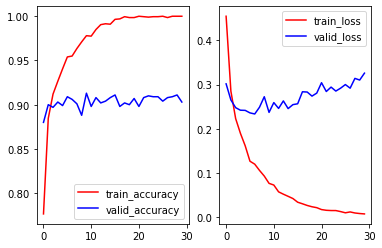

In [1]:
# transfer learning

# keras는 전이학습을 위해서 VGG16을 제공
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',
                   include_top=False,    # FC layer 쓸거니 말거니, imagenet을 학습시킨 FC layer을 이용할거냐는것
                   input_shape=(150,150,3))

# include_top=False로 하면 input_shape을 (224,224,3)으로 잡아야함
# 하지만 (224,224,3)으로 하면 output으로 1000이 나오므로 개와 고양이 데이터는 사용못함
# 개와 고양이는 2개로만 분류하기 떄문에!!


print(model_base.summary())

# 우리가 가지고 있는 데이터(개와 고양이)를 VGG16에 통과시켜서
# activation map을 만들거에요
# ndarray형태로 저장해야함

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')  # ./data/cat_dog_small/train
valid_dir = os.path.join(base_dir, 'validation')  
test_dir = os.path.join(base_dir, 'test')  

datagen = ImageDataGenerator(rescale=1/255)

def extraction_feature(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,))
    
    generator = datagen.flow_from_directory(
        directory,
        classes=['cats','dogs'],
        target_size=(150,150),
        batch_size=20,
        class_mode='binary'
    )
    
    i = 0
    
    for x_data_batch, t_data_batch in generator :
        feature_batch = model_base.predict(x_data_batch)  # 20개 이미지 특성추출
        features[i*20:(i+1)*20] = feature_batch  # [20:40]
        labels[i*20:(i+1)*20] = t_data_batch 
        
        i = i + 1
        
        if i*20 >= sample_count:
            break
            
    return features, labels

train_features, train_labels = extraction_feature(train_dir, 2000)
valid_features, valid_labels = extraction_feature(valid_dir, 1000)
test_features, test_labels = extraction_feature(test_dir, 1000)

# 이 ndarray을 이용해서 DNN학습을 하면 될거 같아요 

train_x_data = np.reshape(train_features, (2000,4*4*512))  # 2차원
train_t_data = train_labels

valid_x_data = np.reshape(valid_features, (1000,4*4*512))  # 2차원
valid_t_data = valid_labels

test_x_data = np.reshape(test_features, (1000,4*4*512))  # 2차원
test_t_data = test_labels

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))
model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x_data,
                    train_t_data,
                    epochs=30,
                    batch_size=20,
                    validation_data = (valid_x_data, valid_t_data))

# history 객체를 이용해서 결과 그래프를 그려보자
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train_accuracy')
ax1.plot(valid_acc, color='b', label='valid_accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train_loss')
ax2.plot(valid_loss, color='b', label='valid_loss')
ax2.legend()

plt.tight_layout()
plt.show()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None
Epoch 1/30


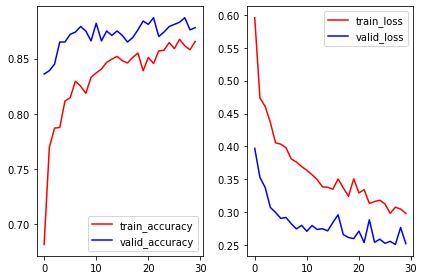

In [9]:
# 이미지 증식을 이용한 전이학습 

import os # 이미지 경로를 잡기위해 필요
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16

train_dir = './data/cat_dog_small/train'
valid_dir = './data/cat_dog_small/validation'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,  # 0~30도 사이의 랜덤값으로 각도 변경
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,   # 상하반전
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    classes=['cats','dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary')   # 다중 분류라면 categorical이라고 치면됨
                                                   
valid_generator = valid_datagen.flow_from_directory(valid_dir, 
                                                    classes=['cats','dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary')


# Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False  # 파라미터 동결, VGG안에(convolution layer) 있는 파라미터 동결시킴

# print(model_base.summary())

# model 구현
model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(4*4*512, )))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='sigmoid'))

print(model.summary())

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50,
                    verbose=2)

model.save('./data/cat_dog_small/transfer_learning_cnn_cat_dog_small.h5')

# history 객체를 이용해서 결과 그래프를 그려보자
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train_accuracy')
ax1.plot(valid_acc, color='b', label='valid_accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train_loss')
ax2.plot(valid_loss, color='b', label='valid_loss')
ax2.legend()

plt.tight_layout()
plt.show()